# Tinkering Notebook for Lecture 1 - Introduction

In this notebook you will see that your Jupyter environment is working, and also try to use reinforcement learning on a simple problem.

# Table of content
* ### [1. Imports](#sec1)
* ### [2. A very short introduction to Reinforcement Learning (RL)](#sec2)
* ### [3. Getting started with Open AI gym](#sec3)
 * #### [3.1 Taxi driver](#sec3_1)
 * #### [3.2 MountainCar environment](#sec3_2)
* ### [4. *Multi-armed bandits](#sec4)
 * #### [4.1 Learn](#sec4_1)
 * #### [4.2 Act](#sec4_2)
 * #### [4.3 Testing MultiarmedBandits](#sec4_3)


# 1. Imports <a id="sec1">

For this notebook you have to import the following packages.

In [1]:
# Packages needed for this assignment
import gym
import gym_bandits #Implements 10-armed bandits from Chapter 2 in the textbook
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output # Used to clear the ouput of a Jupyter cell.

# 2. A very short introduction to Reinforcement Learning (RL) <a id="sec2">

RL is a family of modern machine learning techniques for learning how to make sequential decisions using feedback from real and/or simulated environments. 

In RL the agent (e.g. computer program) interacts with an environment and gets rewards. The environment could be a physical or chemical system, resource management, traffic light control, advertisement network, a computer game or many other things. The goal of the agent is typically to maximize the cumulative sum of rewards over some number of sequential actions. In order to do so, the agent learns from observations in order to improve its future actions. 

Some important concepts in RL:
* __Agent__: The learner and decision maker.
* __Environment__:  What the agent interacts with.
* __State__: A state $s \in \mathcal{S}$ is a succint representation of the environments current state.
* __Action__: The agent can take actions $a \in \mathcal{A}$ in order to change the state of the environment.
* __Observation__: After each action the agent recieves an observation of the environment. For most of the course we will assume that the agent observs the state $s$.
* __Policy__: Rules for how the agent choses the next action given the current state, $a = \pi(s)$.
* __Reward__: An immediate reward $R(s,a)$ that the agent gets for taking action $a$ in state $s$.

For more discussion on the meaning of these concepts, see Lecture 1 and the course book. 

# 3. Getting started with Open AI gym <a id="sec3">

In supervised learning different methods can be evaluated on static data sets. In RL, however, the algorithms must be tested on interactive (dynamic) environments. This is where OpenAI Gym comes in.

[OpenAI Gym](http://gym.openai.com) is a toolkit for comparing RL-algorithms. It contains a wide variety of environments that you can train your agents on, and it is often used for benchmarking new methods in the RL research litterature. 
There are also [leaderboards](https://github.com/openai/gym/wiki/Leaderboard) for different gym-environments, showing which methods has been most successful so far.

In the exercises, "Tinkering Notebooks", we will make use of OpenAI Gym.

To test your installation of OpenAI gym, and learn about basic usage, we will look at the relatively simple Taxi-environment.

## 3.1 Taxi driver <a id="sec3_1">

In this environment there are four locations. Your job is to pick up a passenger at one of these locations, and then drop her of at another location. 

To test this environment run the following lines of code.

In [20]:
env = gym.make('Taxi-v3')
state = env.reset()
print('Initial state:', state)

Initial state: 154


The methods used above are:
* `make()`: Creates a gym environment object. In this case we use the Taxi-environment.
* `reset()`: Resets the environment to an initial state, and returns the initial state. 
In the case of the Taxi-environment, the initial state is chosen randomly, so it will be different every time you run `env.reset()`.

To visualize the current state of the environment, you can use the function `render()`. In the Taxi-environment the visualization is text-based. 

In [21]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



The filled square represents the taxi, the letters (R, G, Y and B) represents possible pickup and destination locations, and | represents a wall. The blue letter is the passenger, and the purple is the destination.

Next we take a look at the state space $\mathcal{S}$ (all possible states) and action space $\mathcal{A}$ (all possible actions). 

In [22]:
print("State space:", env.observation_space)
print("Action space:", env.action_space)

State space: Discrete(500)
Action space: Discrete(6)


__State space__: Contains all possible states of the environment. We see that the state space here contains 500 discrete states. In this case each state corresponds to a position of the taxi (25 possibilities), the passengers position (5 possibilities, including picked up) and the destination (4 possibilities). Hence, there are $25\times5 \times 4 = 500$ possible states.

__Action space__: Contains all possible actions the agent can take. In this case the six discrete actions corresponds to: 0 - south, 1 - north, 2 - east, 3 - west, 4 - pickup, 5 - dropoff. 

***Remark***: Note that we actually asked for the `observation_space` and not the state space. As mentioned above, we will for most of the course assume that the observation space and the state space are the same. However, in some RL-problems the full state cannot be observed, so the space of possible states may not be the same as the space of possible observations. For example, the complete state of an inverted pendulum consists of both the angle and velocity, but maybe only the angle is meausred directly.

We next see how the agent can interact with the environment.

In [28]:
new_state, reward, done, info = env.step(0) # Take action 1 (north)
env.render()
print("New state:", new_state)
print("Reward:", reward)
print("Done:", done)
print("Info:", info)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
New state: 154
Reward: -1
Done: False
Info: {'prob': 1.0}


If it was possible, the taxi should now have moved one step north (if the taxi started at the top row then it will not move). The step-function returns the following information:
* __New state__: The state after the action is taken.
* __Reward__: The immediate reward. In the taxi-environment the reward for illegal "pickup" or "dropoff" is -10, successfully delivering the passenger gives +20, and any other action gives -1.
* __Done__: Is the environment done? In the Taxi-environment this will be false until the passenger is successfully dropped at her destination, or the number of actions taken gets larger than 200.
* __info__: Additional information mainly used for debugging.

The goal of the agent is to maximize the total reward. In this environment this means to deliver the passenger to her destination in as few steps as possible. If more than 200 actions are taken we will stop even if the passenger is not at her destination.

One (quite bad) strategy for the taxi problem is to take a random action every time. Inside a gym-environment this can be done using `env.action_space.sample()`, which samples a random action from the action space. Look through the following loop and make sure that you understand whats going on. (We use `clear_output()` to clear the output of the Jupyter cell, and `time.sleep()` to pause between each action)

In [6]:
env.reset()
time_step = 0
total_reward = 0
done = False
while not done:
    action = env.action_space.sample() #Choose random action
    state, reward, done, info = env.step(action) 
    total_reward += reward
    time_step += 1
    clear_output(wait=True)
    env.render()
    print("Time step:", time_step)
    print("Reward:", reward)
    print("Total reward:", total_reward)
    time.sleep(.05)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Time step: 200
Reward: -1
Total reward: -830


As you can see, random actions is, unsurprisingly, not a good policy. However, if the agent has no prior information about the environment or the goal, what else could it do?

If we know everything about the environment, we could create an array with 500 entries, where each entry tells us what the optimal action is in the corresponding state. One way of finding this array is to use dynamic programming. This will be discussed in Lecture 3.

In Lecture 4 and Lecture 5 we will see how the agent can learn the array without prior knowledge, by just observing the reward received for taking different actions in different states.

## 3.2 MountainCar environment <a id="sec3_2">

In the course we will use some environments where `render()` uses more advanced graphics. In order to make sure that this works on your installation, we also test the *MountainCar*-environment.

In this case, `render()` opens a new window where the current state of the environment is visualized. 
If you want to close this window you call `env.close()`. If you have overwritten __env__ for some reason, you will have to restart your Jupyter kernel in order to close the window.

***Remark:*** We call render two times. This should not be needed, but sometimes on Windows the first call only opens the window without actually rendering the frame.

In [34]:
env = gym.make('MountainCar-v0')
env.reset()
env.render()
env.render() 
print("State space:", env.observation_space, "Low:", env.observation_space.low, "High:", env.observation_space.high)
print("Action space:", env.action_space)

State space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32) Low: [-1.2  -0.07] High: [0.6  0.07]
Action space: Discrete(3)


In [35]:
env.close()

*  __Action space__: We have three discrete actions, 0 - push left, 1 - no push, 2 - push right
* __State space__: `Box(2,)` represents a two dimensional box, so it is a continuous space. Each state is a vector with two elements. In MouintainCar the first element is the position of the car, and can go between -1.2 and +0.6. The second element is the velocity of the car and can go between -0.07 and +0.07.
* __Reward__: The reward given by the environment is -1 for each action. 
* __Done__: The environment is done when the flag is reached (position = 0.5), or 200 actions have been used. The goal is thus to reach the flag in as few steps as possible. 

Lets first try to solve this environment by the simple policy: Always push the car right (action = 2).

In [36]:
def policy(state):
    p, v = state
    if min(-0.09*(p+0.25)**2+0.03, 0.3*(p+0.9)**4-0.008) <= v and\
    v <= -0.07*(p+0.38)**2+0.07:
        return 2
    else:
        return 0

In [37]:
env = gym.make('MountainCar-v0')
state = env.reset()
time_step = 0
total_reward = 0
done = False
while not done:
    action = policy(state)
    state, reward, done, info = env.step(action)
    total_reward += reward
    env.render()
    
    clear_output(wait=True)
    print("State:", state)
    print("Action:", action)
    print("Total reward:", total_reward)
    
    time.sleep(.02)
env.close()

State: [0.513535  0.0209435]
Action: 0
Total reward: -104.0


Unfortunately the car does not have the momentum to overcome gravity, and thus it never reaches the flag. The agent must learn that the car needs to gain momentum by going up the left hill.

This environment is harder than the Taxi-enivronment for RL-agents. There are two reasons for this:
1. The state-space is continuous (infinitely many states). Hence, it is not possible to build up a table with information about all states. In RL this can be solved using function approximations. This will be discussed in the second half of the course.

2. The agent always gets the immediate reward -1 for each action until it reaches the flag. So all actions looks just as bad if we do not reach the flag within 200 steps, and it is very unlikely that the car reaches the flag by only using e.g. random actions. So how can it learn about the goal? We will see two possible solutions in the course: We can try to re-engineer the reward so that the agent is encouraged to go up the left slope first. Or more generally, we can encourage the agent to try to reach states that has not been seen before.

Even though the problem is hard for an RL-agent that knows nothing about the environment, it is relatively easy for an engineer that knows the basics of the environment to find a policy that reaches the flag within 200 steps. The strength of RL is that the agent can learn these only by interacting with the environment. However, when we know more about the environment it can still be much more efficient to let an engineer figure out a good policy, and then potentially use RL to improve this policy.

***
### Task:
a) Try to construct a policy that only uses the current velocity (`state[1]`) to determine the action. The goal is to reach the flag within 200 steps. Implement your policy in the function `policy` above and try it. Remember to execute the cell with the function after you have made your changes. *Hint:* It is actually enough to check in which direction the car is currently moving.

b) Implement the policy that is on the leaderboard for MountainCar-v0: ($p$ is position,  $v$ is velocity, and the state is $s = \begin{bmatrix} p & v \end{bmatrix}^\top$)
$$
\pi(s) = \begin{cases} \text{Right} & \text{if } \min\{-0.09( p + 0.25)^2 + 0.03, 0.3(p + 0.9)^4 - 0.008\} \leq v \leq -0.07(p+0.38)^2 + 0.07 \\ \text{Left} & \text{otherwise} \end{cases}
$$

***

# 4. *Multi-armed bandits <a id="sec4">

This part of the assignment is based on Chapter 2 in the textbook. It will give you a test of many of the ideas in RL.

To get a more complete discussion you can read through Section 2.1-2.6. Below a short summary of these sections is given. After this you can implement and test some relatively simple RL-algorithm.

Assume that you have 10 slot machines (one-armed bandits) in front of you. Each slot machine has an expected reward that is unknown to you. You will get to choose between the slot machines 1000 times, and your goal is to get as large total reward as possible. 

This problem is called a multi-armed bandit problem. Now we formulate this as an RL-problem:
* __Action space__: $\mathcal{A} = \{ 0, 1, \ldots, 9\}$, so action $a=0$ means that we try slot machine $0$, $a=1$ means we try slot machine $1$ etc.
* __State space__: Since the slot machines do not change between each action, there is just one state. This simplifies the problem: The environment does not change when an action is taken. Hence, the agent can concentrate on the immediate reward  it gets for each action, and it does not have to worry about how the action changes the state of the environment. 
* __Reward__: The return $R$ we get from the slot machine we picked. 

In order to formalize our goal, we define the value of an action, $q_*(a)$, to be the expected reward when $a$ is chosen, i.e., $q_*(a) = \mathbb{E}[ R | a]$. Note that $q_*(a)$ can be represented by an array with 10 elements, where each element gives the value for the corresponding action.


If we know the value function $q_*(a)$, the optimal policy is to always choose the action

$$
A = \underset{a}{\operatorname{argmax}} q_*(a).
$$

## 4.1 Learn <a id="sec4_1">

However, we do not know what $q_*(a)$ is. An option is to try $n-1$ actions in order to get an estimate $Q_n(a)$ of the expected reward for each slot machine. A reasonable estimate of the the expected reward for a specific action $a$ is the average reward  seen so far when we have taken action $a$. That is, when $n-1$ actions have been taken, we can compute an estimate of $q_*(a)$ as

$$
Q_n(a) = \frac{ \text{ sum of rewards when $a$ taken prior to $n$} }{\text{number of times $a$  taken prior to $n$}} \quad \text{(see eq 2.1 in textbook)},
$$

where we let $Q_n(a) = 0$ if the action $a$ was not taken prior to the $n$th action. In particular, $Q_1(a) = 0$ for all $a$.

Instead of recomputing the sums every time a new action is taken, we can update this sums incrementally. Equation (2.3) in the textbook shows how to do this. That is, if the $n$th action taken is $A_n$, and the received reward is $R_n$, then $Q_{n+1}(A_n)$ can be computed from $Q_n(A_n)$ as


$$
Q_{n+1}(A_n) = Q_{n}(A_n) + \frac{1}{N(A_n)}(R_n - Q_n(A_n))
$$
where $N(A_n)$ is the number of times that $A_n$ has been taken so far.

If we initialize the estimate to $Q_1(a) = 0$ for all $a \in \mathcal{A}$, then both expressions for $Q_n(a)$ are equivalent. For implementation the second expression is quite useful. Here we only need to create an array with 10 elements (one for each possible action) and whenever action $a$ is taken and the reward is observed, we update element $a$ in the array. 
Pseudo-code for this can be written as

*Initialize:*

For all $a \in \mathcal{A}$, 
  * $\quad Q(a) \leftarrow 0$
  * $\quad N(a) \leftarrow 0$
  
*Learn:*

When action $A$ is taken with received reward $R$, update the estimates:
  * $N(A) \leftarrow N(A) + 1$
  * $Q(A) \leftarrow Q(A) + \frac{1}{N(A)} (R - Q(A))$

## 4.2 Act <a id="sec4_2">

Given an estimate $Q(a)$, how should the agent choose the next action? 

A straightforward answer is to pick the one that maximizes $Q(a)$. This is in RL called the *greedy* choice, picking the action that according to the current estimates seems best.

The problem with the greedy choice is that the estimates may be incorrect. If the current estimate of the optimal action's value is too low then the greedy agent will not take that action, and thus never update the estimated value of it. In other word, the agent is not exploring all possibilities. A simple, but often quite effective, way of adding exploration is that the agent use the greedy option most of the time, but with probability $\varepsilon$ it takes a random action.
This is called an $\varepsilon$-greedy policy. In this way the agent will always continue to explore different possibilities. The $\varepsilon$-greedy policy given an estimate $Q(a)$ can be written as

$$
 \begin{cases} \underset{a}{\operatorname{argmax}} Q(a) & \text{with probability } 1-\varepsilon \\ \text{random action} & \text{with probability } \varepsilon\end{cases}
$$

When several actions have an estimate equal to the maximum, the agent can break ties any way it wants (e.g. randomly). 

## 4.3 Testing MultiarmedBandits <a id="sec4_3">

In OpenAI gym, the multi-armed bandits are implemented in the `MultiarmedBandits-v0` environment. This environment is not in the standard gym package, so to use it you have to  `import gym_bandits`. 

Below you can see an example of how to use this environment. A class `Agent` is used to implement an agent that does not learn anything, and always chooses a random action. 
In the exercise below you will change the code in this class in order to implement the methods described above (and in Chapter 2 of the textbook).

*Remark:* The environment is by default a 10-armed bandit. If you want e.g. a 15-armed bandit, you can use `env = gym.make('MultiarmedBandits-v0', nr_arms=15)`. If you want to see what the true $q_*(a)$ is, you can use `env.values` (this will of course change everytime you call `env.reset()`). This can be interesting if you want to compare it to the estimated $Q$ that your agent has learned.

In [11]:
env = gym.make("MultiarmedBandits-v0")
print('State space:', env.observation_space)
print('Action space:', env.action_space)

State space: Discrete(1)
Action space: Discrete(10)


In [12]:
class Agent():
    
    def __init__(self, epsilon=0, nr_arms=10):
        self.epsilon = epsilon
        self.nr_arms = nr_arms
        self.N = np.zeros(nr_arms)
        self.Q = np.zeros(nr_arms)
        
    def learn(self, action, reward):
        self.N[action] += 1
        self.Q[action] = self.Q[action] + (reward - self.Q[action])/(self.N[action])        
    
    def act(self):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.nr_arms) # Random action
        else:
            argmax_Q = [count for count, element in enumerate(self.Q) if element == max(self.Q)]
            action = np.random.choice(argmax_Q)
        return action

In [13]:
env.reset()
agent = Agent(epsilon = 0.1)
rewards = np.empty(1000)
for t in range(1000):
    action = agent.act()
    state, reward, done, info = env.step(action)
    rewards[t] = reward
    agent.learn(action, reward)

print('Total reward: %.2f' % np.sum(rewards))
print(agent.Q)

Total reward: 1031.43
[ 1.19957086  0.47143618  0.53749277 -0.67909461  1.00369416  0.47306307
 -1.30424458 -1.71035798 -0.91422772  0.10338572]


In [14]:
np.random.choice([2, 10])

10

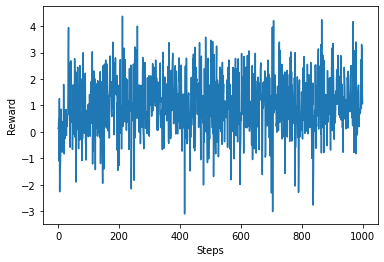

In [15]:
# Plot the reward given for each action
plt.plot(rewards)
plt.xlabel('Steps')
plt.ylabel('Reward');

***
### Exercise

a) Change the `Agent`-class in order to implement an $\varepsilon$-greedy agent. To do this, change the `learn`-method to implement the update of $Q$ given an action with corresponding reward. Then implement the $\varepsilon$-greedy policy in the `act`-function.  

b) Try to run your agent with e.g. $\varepsilon = 0.1$.

d) When you have tested that your implementation, you can run the code below the reproduce plots like in Figure 2.2 in the textbook. Here we do 2000 runs using the agent, and then take the average reward at different time steps. The code may take some minute to run!
***

In [16]:
epsilon = 0.1 # Change this to try different values
rewards = np.zeros((2000, 1000)) 

for i in range(2000):
    agent = Agent(epsilon = epsilon)
    env.reset()
    
    for t in range(1000):
        action = agent.act()
        state, reward, done, info = env.step(action)
        rewards[i,t] = reward
        agent.learn(action, reward) 

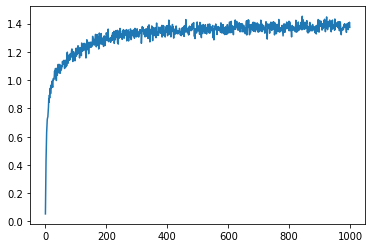

In [17]:
mean_rewards = np.mean(rewards, 0)
plt.plot(mean_rewards)